1. Set Up Environment and Libraries

First, ensure you have PyTorch and other necessary libraries installed. You will also need matplotlib for plotting the confusion matrix and torchvision for utilities and models:

In [12]:
!pip install torch torchvision matplotlib scikit-learn seaborn

DEPRECATION: Loading egg at /opt/carla-simulator/PythonAPI/carla/dist/carla-0.9.13-py3.7-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


2. Prepare the Dataset

You will need to load and preprocess your dataset. This involves resizing images, normalizing them, and creating dataloaders:

In [13]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = 'garbage classification/Garbage classification'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


3. Set Up the Model

Load the ResNet-50 model, modifying it for your number of classes, and set up the loss function and optimizer:

In [14]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))  # Adjust for your number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/mingwei/anaconda3/envs/distribution/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mingwei/anaconda3/envs/distribution/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


4. Training Loop

Define the training loop and train the model:

In [15]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1} Loss: {running_loss/len(train_loader)}')

train_model(model, criterion, optimizer, train_loader)


Epoch 1 Loss: 1.1485352162271738
Epoch 2 Loss: 0.9325489257462323
Epoch 3 Loss: 0.7737343315966427
Epoch 4 Loss: 0.6597499058116227
Epoch 5 Loss: 0.5246516258921474
Epoch 6 Loss: 0.5456946175545454
Epoch 7 Loss: 0.3972705330234021
Epoch 8 Loss: 0.41180531843565404
Epoch 9 Loss: 0.31360654765740037
Epoch 10 Loss: 0.2558300428208895
Epoch 11 Loss: 0.2757799359969795
Epoch 12 Loss: 0.2998628520872444
Epoch 13 Loss: 0.5004771985113621
Epoch 14 Loss: 0.356633203336969
Epoch 15 Loss: 0.1946473706921097
Epoch 16 Loss: 0.1561333029239904
Epoch 17 Loss: 0.17668206596863456
Epoch 18 Loss: 0.11397161547210999
Epoch 19 Loss: 0.23603451595408842
Epoch 20 Loss: 0.10944502375787124


5. Evaluate the Model

Evaluate the model using the test set and create a confusion matrix:

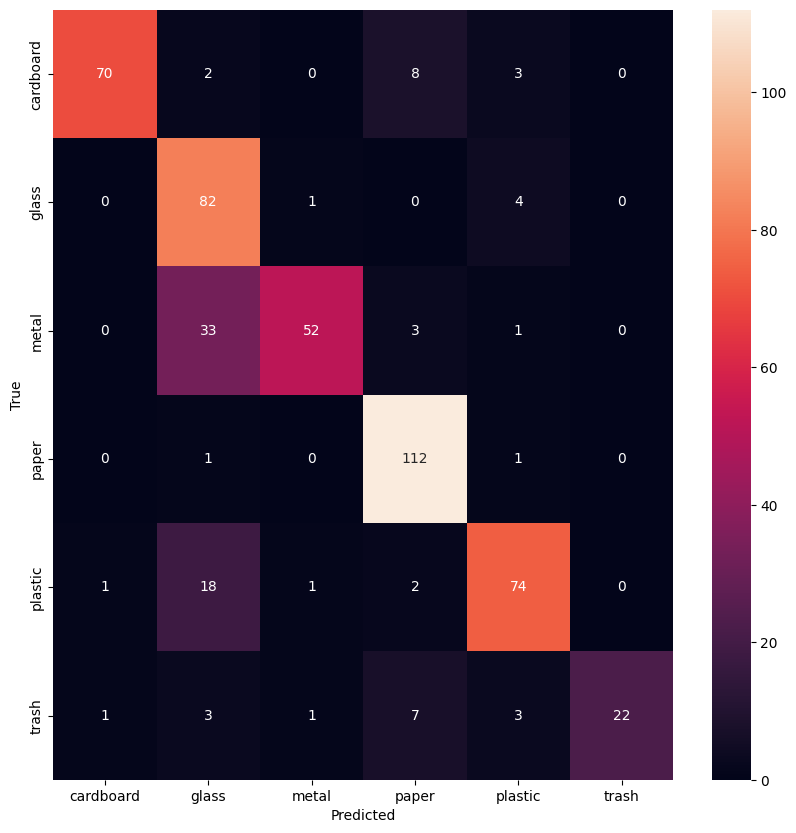

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions and labels
predictions, labels = evaluate_model(model, test_loader)

# Confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
